In [20]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

w = 160
h = 90

# 输入形状: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, w, h))  

y = MultiBoxPrior(x, sizes=[0.0417], ratios=[0.5625])

# 取位于 (20,20) 像素点的第一个预设框
# 格式为 (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[-0.03151111  0.494775    0.04262222  0.536475  ]
<NDArray 4 @cpu(0)>


# 分类预测

总共一个anchor,9类


class_predictor和box_predictor返回的是类的概率

In [21]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(1, 9)
cls_pred.initialize()
x = nd.zeros((2, 3, 5, 5))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 10, 5, 5)


# 框偏移预测

In [23]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(1)
box_pred.initialize()
x = nd.zeros((2, 3, 5, 5))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 4, 5, 5)


# 下采样特征层 Down-sample features

每次我们下采样特征层到一半的长宽，用Pooling(池化)操作就可以轻松的做到，当然也可以用stride(步长)为2的卷积直接得到。在下采样之前，我们会希望增加几层卷积层作为缓冲，防止特征值对应多尺度带来的混乱，同时又能增加网络的深度，得到更好的抽象。

下面的num_filters是输出层的个数

In [24]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


# 主干网络 Body network

主干网络用来从原始图像输入提取特征。 一般来说我们会用预先训练好的用于分类的高性能网络（VGG, ResNet等）来提取特征。

在这里我们就简单地堆叠几层卷积和下采样层作为主干网络的演示。

In [25]:
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


# 设计一个简单的单尺度检测网络 Create a toy sing scale detection model

我们这里介绍一个示意用的简单单尺度网络

In [27]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    #downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    for scale in range(1):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), class_preds, box_preds

print(toy_ssd_model(1, 9))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (2): HybridSequential(
    (0): C

# 网络前向推导 Forward



In [32]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))
def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [30]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(1):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        

    return default_anchors, predicted_classes, predicted_boxes

# 整个网络

In [33]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # 1个预测层
        self.anchor_sizes = [[0.0417]]
        # 每层的预设框都用 1，2，0.5作为长宽比候选
        self.anchor_ratios = [[0.5625]]
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(1, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # 把从每个预测层输入的结果摊平并连接，以确保一一对应
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # 改变下形状，为了更方便地计算softmax
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

# 加载数据 Load dataset

加载数据可以用mxnet.image.ImageDetIter，同时还提供了大量数据增强的选项，比如翻转，随机截取等等。

In [46]:
ls

UTS_01/                  labelImg/            pack.zip  xmls/
ball_detection.md.ipynb  labelImg-master/     val.idx   新建文本文档.txt
class_list/              labelImg-master.zip  val.lst
images/                  mxnet/               val.rec


In [52]:
import mxnet.image as image
data_width1  = 720
data_height1 = 1080
batch_size = 6
def get_iterators(data_width,data_height, batch_size):
    class_names = ['chi','cheng','hong','lv','qing','lan','lan','zi','bai']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_width, data_height),
        #path_imgrec='./data/pikachu_train.rec',
        #path_imgidx='./data/pikachu_train.idx',
        path_imglist='./images/train.lst',
        path_root='./images/',
        mean=True)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_width, data_height),
        path_imglist='./images/train.lst',
        path_root='./images/',
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_width1, data_height1, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(6, 3, 720, 1080)] label shapes: [(6, 8, 5)]


[ 0.          0.45468751  0.55000001  0.48593751  0.60555553]
[ 7.          0.41093749  0.69861114  0.44218749  0.75416666]
[ 3.          0.40390626  0.32777777  0.43515626  0.38333333]
[ 5.          0.62187499  0.48333332  0.65312499  0.53888887]
[ 8.          0.66171873  0.70833331  0.69296873  0.7638889 ]
[ 2.          0.40156251  0.47222221  0.43281251  0.52777779]
[ 4.          0.65234375  0.38472223  0.68359375  0.44027779]
[ 1.          0.203125    0.32083333  0.234375    0.37638888]


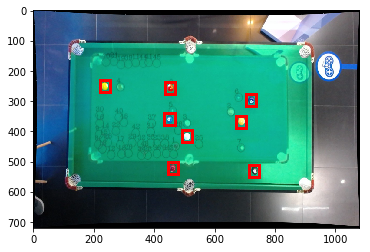

In [54]:
import numpy as np
import matplotlib.pyplot as plt

img = batch.data[0][0].asnumpy()  # 取第一批数据中的第一张，转成numpy
img = img.transpose((1, 2, 0))  # 交换下通道的顺序
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # 图片应该用0-255的范围
# 在图上画出真实标签的方框
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin = label[1] * data_height1
    ymin = label[2] * data_width1
    xmax = label[3] * data_height1
    ymax = label[4] * data_width1
    #xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()